In [70]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

/tmp/ipykernel_19457/82325636.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [98]:
# Load experimental results from files.

from pathlib import Path
import re
import yaml
from yaml import SafeLoader

EXP_PATH = "/home/hazrael/GitRepositories/storalloc-gitlab/simulation/results"
# EXP_NAME = ["exp__08-Mar-22_11-14", "exp__09-Mar-22_09-46", "exp__09-Mar-22_13-05"]
EXP_NAME = ["exp__17-Mar-22_17-20"]
#EXP_NAME = ["exp__17-Mar-22_10-11", "exp__17-Mar-22_11-34", "exp__17-Mar-22_13-43"]

exp_data = []

infra_pattern = re.compile(r"infra\d+TB")
system_pattern = re.compile(r"(single|multi)(_[a-z]+){3}")
algo_pattern = re.compile(r"(\S+)_infra\d+TB")

for name in EXP_NAME:
    exp_path = Path(f"{EXP_PATH}/{name}")
    result_files = exp_path.glob("*.yml")

    for file in result_files:
        with open(file, "r", encoding="utf-8") as yaml_file:
            exp = yaml.load(yaml_file, Loader=SafeLoader)
            exp["full_name"] = file.stem.split('__')[1]
            exp["infra"] = infra_pattern.findall(exp["full_name"])[0]
            exp["system"] = system_pattern.search(exp["full_name"])[0]
            exp["algo"] = algo_pattern.search(exp['full_name'])[1]
            exp_data.append(exp)

In [99]:
# Load them (almost) unprocessed into a DataFrame

import pandas as pd

df_data = pd.DataFrame(exp_data)
# df_data

In [100]:
# Compute some means (per node / disk) extracted from the "nodes" column 
# and add them as new columns in the original dataset

# New columns
mean_node_alloc = [] # extracted from existing field
max_node_alloc = []
mean_node_utilisation = []


for idx, row in df_data.iterrows():

    acc_mean_node_alloc = []
    acc_max_disk_alloc = []
    acc_mean_cap_utilisation = []
    # print(row['nodes'])
    ## NODES
    for node in row["nodes"]:
        # print(node)
        
        acc_mean_node_alloc.append(node["mean_nb_alloc"])
        
        max_disk_alloc = []
        mean_disk_alloc = []
        max_cap_utilisation = []
        mean_cap_utilisation = []

        # DISKS
        for disk in node["disks"]:
            # print(disk["max_alloc"])
            acc_max_disk_alloc.append(disk["max_alloc"])
            mean_disk_alloc.append(disk["mean_nb_alloc"])
            max_cap_utilisation.append(disk["max_cap_utilisation"])
            mean_cap_utilisation.append(disk["mean_capacity_utilisation"])
        
        
        mean_disk_alloc = pd.Series(mean_disk_alloc).mean()
        acc_mean_cap_utilisation = pd.Series(mean_cap_utilisation).mean()
        
    
    # Building future column for DataFrame
    mean_node_alloc.append(pd.Series(acc_mean_node_alloc).mean())
    max_node_alloc.append(max(acc_max_disk_alloc))
    mean_node_utilisation.append(pd.Series(acc_mean_cap_utilisation).mean())
    
    
df_data["mean_node_alloc"] = mean_node_alloc
df_data["max_node_alloc"] = max_node_alloc
df_data["mean_node_utilisation"] = mean_node_utilisation

In [101]:
df_data.describe()

,max_concurrent_allocations,nb_of_delayed_requests,nb_of_registrations,nb_of_requests,nb_of_scheduler_failures,sim_duration,sim_first_ts,sim_last_ts,tt_gb_allocated,tt_gb_deallocated,tt_waiting_time_minutes,mean_node_alloc,max_node_alloc,mean_node_utilisation
count,16.000000,16.0,16.0,16.0,16.000000,1.600000e+01,1.600000e+01,1.600000e+01,16.000000,16.000000,16.0,16.000000,16.000000,16.000000
mean,9.250000,0.0,1.0,294.0,89.750000,2.553946e+06,1.601549e+09,1.604102e+09,94716.244624,94716.244624,0.0,0.606883,4.437500,6.095555
std,1.183216,0.0,0.0,0.0,29.584906,6.515902e+03,0.000000e+00,6.515902e+03,31822.903958,31822.903958,0.0,0.451487,3.932239,4.181933
min,8.000000,0.0,1.0,294.0,56.000000,2.543018e+06,1.601549e+09,1.604092e+09,32265.902292,32265.902292,0.0,0.101500,2.000000,1.181000
25%,8.000000,0.0,1.0,294.0,71.500000,2.553946e+06,1.601549e+09,1.604102e+09,96888.880060,96888.880060,0.0,0.191094,2.000000,3.582594
50%,9.000000,0.0,1.0,294.0,85.000000,2.557588e+06,1.601549e+09,1.604106e+09,108074.826368,108074.826368,0.0,0.558750,2.000000,5.828500
75%,10.250000,0.0,1.0,294.0,90.250000,2.557588e+06,1.601549e+09,1.604106e+09,110519.862827,110519.862827,0.0,0.966000,5.000000,6.963125
max,11.000000,0.0,1.0,294.0,145.000000,2.557588e+06,1.601549e+09,1.604106e+09,122089.309242,122089.309242,0.0,1.227000,11.000000,17.712500


In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

df_data = df_data.sort_values(["system"], ascending=True)

categorical_theme = {
    "context": "paper",            
    "palette": "Paired", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}

categorical_theme_2 = {
    "context": "paper",            
    "palette": "husl", 
    "style": "whitegrid", 
    "rc": {
        "axes.spines.right":False, 
        "axes.spines.top": False,
    }
}


algo_order = ["random", "rr", "worst_fit", "worst_case"]
infra_order = ["infra8TB", "infra16TB", "infra64TB"]

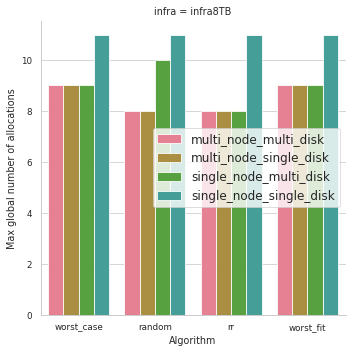

In [103]:
sns.set_theme(**categorical_theme_2)

# --- MAX CONCURRENT ALLOCATIONS (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_concurrent_allocations", hue="system", col="infra", 
    # col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Max global number of allocations", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

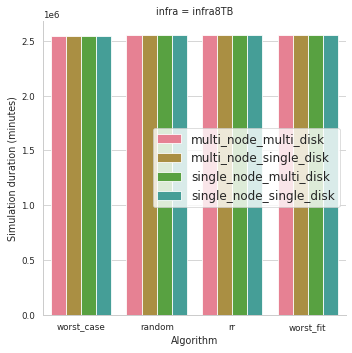

In [104]:
sns.set_theme(**categorical_theme_2)

# --- SIMULATION DURATION (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="sim_duration", hue="system", col="infra", 
    #col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Simulation duration (minutes)", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

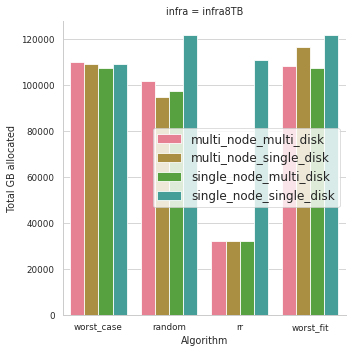

In [105]:
sns.set_theme(**categorical_theme_2)

# --- TOTAL GB ALLOCATED (ALL NODES)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_gb_allocated", hue="system", col="infra", 
    #col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Total GB allocated", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

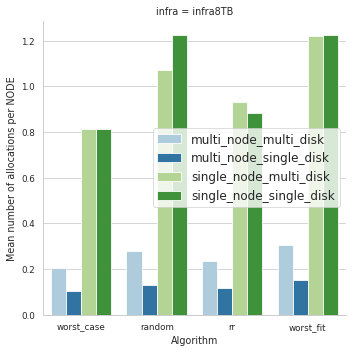

In [106]:
# [1] --- Mean number of allocations per node, for every algorithm

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="mean_node_alloc", hue="system", col="infra", 
    # col_order=infra_order, order=algo_order,sharey="row",
    height=5, legend=False
)
g.set(ylabel="Mean number of allocations per NODE", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")


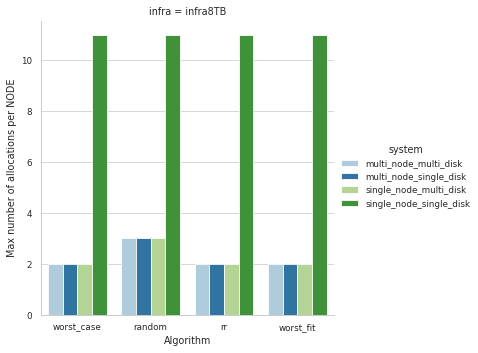

In [107]:
# [2] ---  Max number of allocations per node, for every algo (main parameters of the simulation are in its name)

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="max_node_alloc", hue="system", col="infra",
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5
)
g.set(ylabel="Max number of allocations per NODE", xlabel="Algorithm")

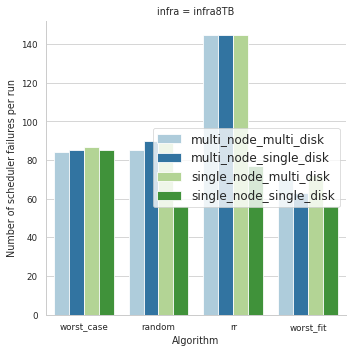

In [110]:
# [3] ---  Total number of scheduler failures, for every simulation

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_scheduler_failures", hue="system", col="infra", 
    #col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of scheduler failures per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

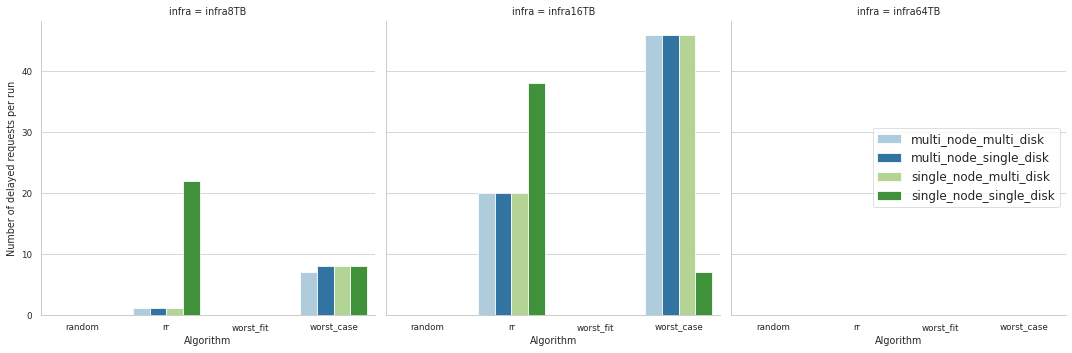

In [8]:
# [4] ---  Total number of delayed requests, for every simulation 

sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="nb_of_delayed_requests", hue="system", col="infra",
    col_order=infra_order, order=algo_order, sharey="row",
    height=5, legend=False
)
g.set(ylabel="Number of delayed requests per run", xlabel="Algorithm")
plt.legend(fontsize="12", loc="right")

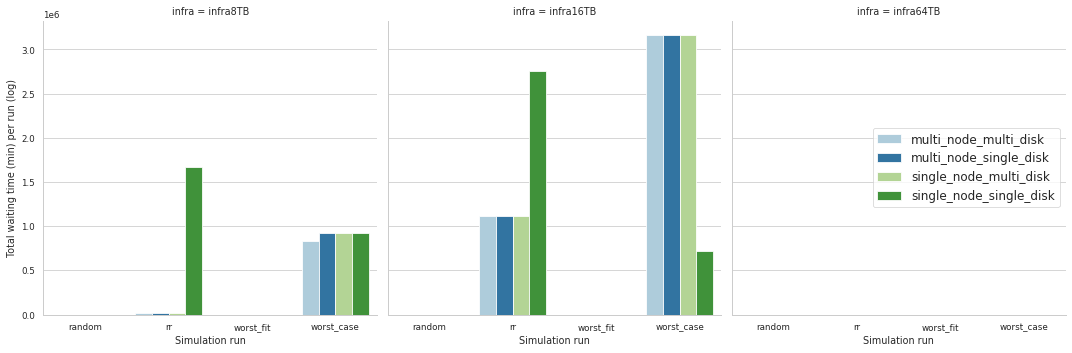

In [28]:
# [5] ---  Total cumulated waiting time for delayed requests, for every simulation
sns.set_theme(**categorical_theme)

g = sns.catplot(
    data=df_data, kind="bar",
    x="algo", y="tt_waiting_time_minutes", hue="system", col="infra",
    col_order=infra_order, order=algo_order, # sharey=False,
    height=5, legend=False
)
# g.set(yscale="log")
g.set(ylabel="Total waiting time (min) per run (log)", xlabel="Simulation run")
plt.legend(fontsize="12", loc="right")

In [29]:
# [6] ---  Create a second dataset where each row is a disk (instead of having one simulation per row)

data_by_disk = {
    "run_name": [],
    "node_id": [],
    "disk_id": [],
    "full_disk_id": [],
    "disk_mean_nb_alloc": [],
    "disk_max_nb_alloc": [],
    "disk_mean_cap_percent": [],
    "disk_max_cap_percent": [],
    "disk_capacity": [],
    "infra": [],
    "system": [],
    "algo": []
}

for idx, row in df_data.iterrows():
    for node in row['nodes']:
        for disk in node["disks"]:
            data_by_disk["run_name"].append(row['full_name'])
            data_by_disk["node_id"].append(node['id'])
            data_by_disk["disk_id"].append(disk['id'])
            data_by_disk["full_disk_id"].append(f"{node['id']}:{disk['id']}")
            data_by_disk["disk_mean_nb_alloc"].append(disk['mean_nb_alloc'])
            data_by_disk["disk_max_nb_alloc"].append(disk['max_alloc'])
            data_by_disk["disk_mean_cap_percent"].append(disk['mean_capacity_utilisation'])
            data_by_disk["disk_max_cap_percent"].append(disk['max_cap_utilisation'])
            data_by_disk["disk_capacity"].append(disk['capacity'])
            data_by_disk["infra"].append(row['infra'])
            data_by_disk["system"].append(row['system'])
            data_by_disk["algo"].append(row['algo'])
    
data_by_disk = pd.DataFrame(data_by_disk)
data_by_disk

,run_name,node_id,disk_id,full_disk_id,disk_mean_nb_alloc,disk_max_nb_alloc,disk_mean_cap_percent,disk_max_cap_percent,disk_capacity,infra,system,algo
0,worst_fit_infra16TB_multi_node_multi_disk_IOJobs,S-7362c7:0,0,S-7362c7:0:0,0.425,44,2.600,100.000,2000,infra16TB,multi_node_multi_disk,worst_fit
1,worst_fit_infra16TB_multi_node_multi_disk_IOJobs,S-7362c7:0,1,S-7362c7:0:1,0.364,43,3.200,100.000,2000,infra16TB,multi_node_multi_disk,worst_fit
2,worst_fit_infra16TB_multi_node_multi_disk_IOJobs,S-7362c7:1,0,S-7362c7:1:0,0.534,169,2.437,100.000,2000,infra16TB,multi_node_multi_disk,worst_fit
3,worst_fit_infra16TB_multi_node_multi_disk_IOJobs,S-7362c7:1,1,S-7362c7:1:1,0.326,39,2.548,100.000,2000,infra16TB,multi_node_multi_disk,worst_fit
4,worst_fit_infra16TB_multi_node_multi_disk_IOJobs,S-7362c7:2,0,S-7362c7:2:0,0.345,28,2.423,100.000,2000,infra16TB,multi_node_multi_disk,worst_fit
...,...,...,...,...,...,...,...,...,...,...,...,...
295,worst_fit_infra16TB_single_node_single_disk_IO...,S-b4432f:0,0,S-b4432f:0:0,3.065,183,2.765,98.907,16000,infra16TB,single_node_single_disk,worst_fit
296,rr_infra8TB_single_node_single_disk_IOJobs,S-6c60d2:0,0,S-6c60d2:0:0,2.942,178,4.119,99.969,8000,infra8TB,single_node_single_disk,rr
297,rr_infra64TB_single_node_single_disk_IOJobs,S-82c9d4:0,0,S-82c9d4:0:0,3.065,183,0.601,45.588,64000,infra64TB,single_node_single_disk,rr
298,worst_case_infra16TB_single_node_single_disk_I...,S-e1f51c:0,0,S-e1f51c:0:0,0.808,25,2.575,99.719,16000,infra16TB,single_node_single_disk,worst_case


In [30]:
data_by_disk = data_by_disk.sort_values(["algo",], ascending=True)

In [31]:
categorical_theme_disk = {
    "context": "paper",            
    "palette": "colorblind", 
    "style": "whitegrid", 
}

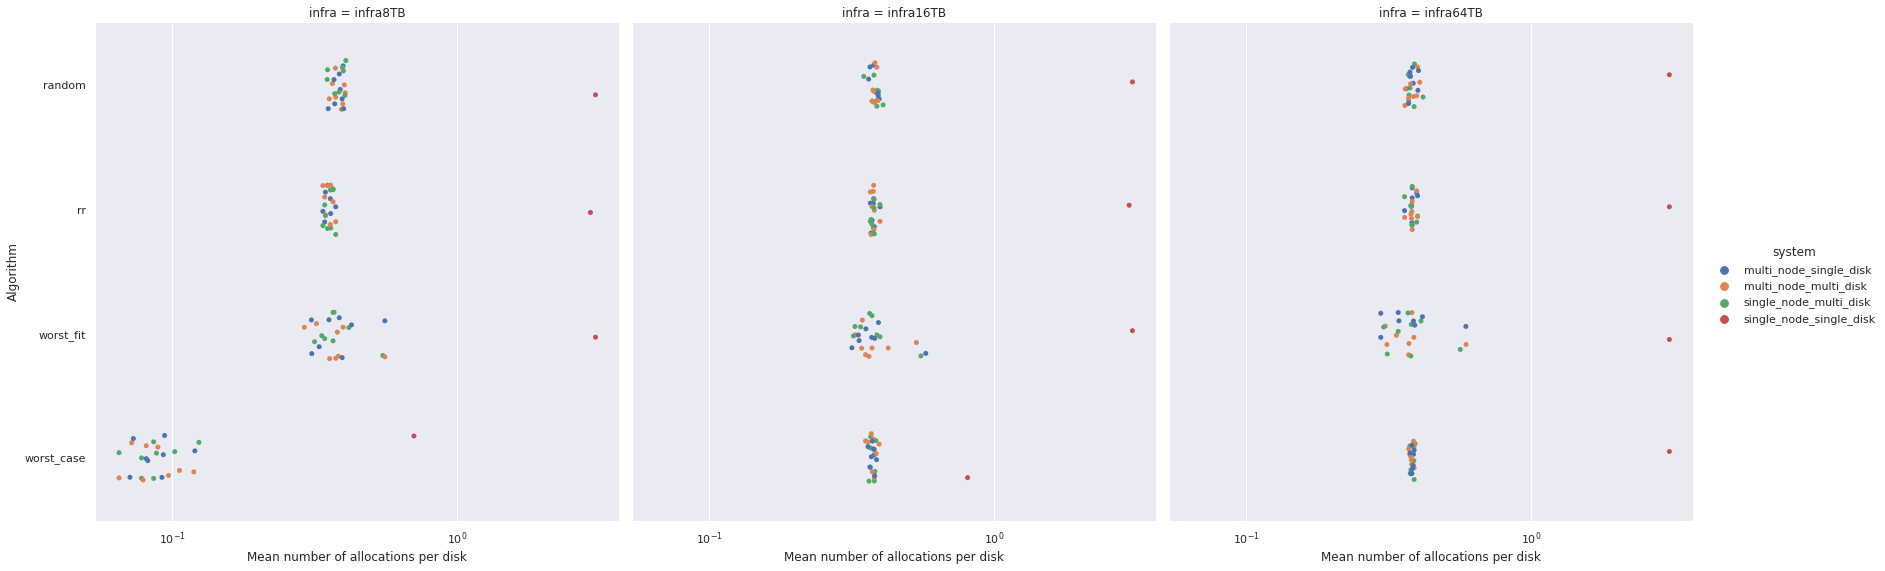

In [33]:
# [7] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

sns.set(rc={'figure.figsize':(11.7,8.27)})
# sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip",
    y="algo", x="disk_mean_nb_alloc",hue="system", col="infra",
    height=8, jitter=0.2, col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Mean number of allocations per disk", "Algorithm")

[Text(0, 0.5, 'Simulation run'),
 Text(0.5, 0, 'Mean number of allocations per node')]

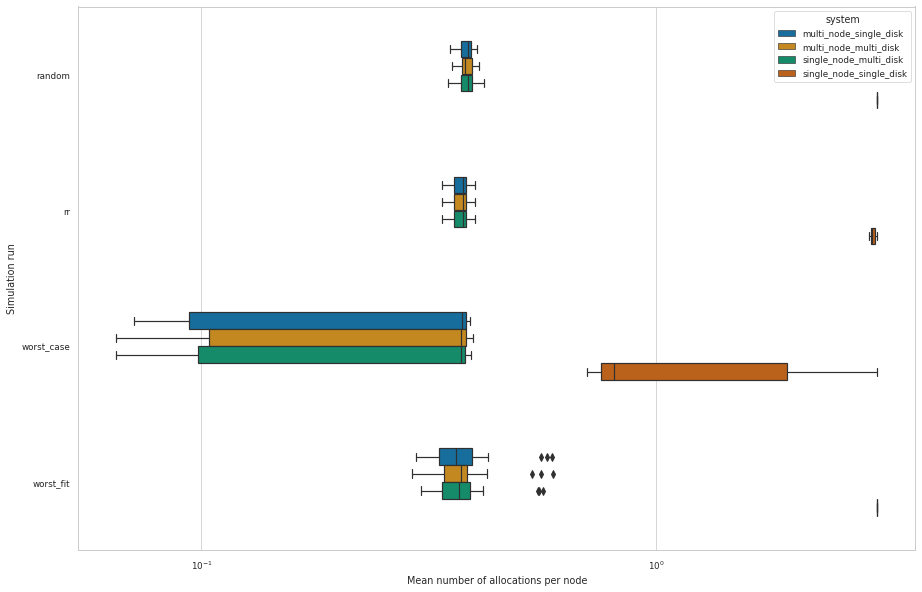

In [41]:
# [8] ---  Mean number of allocations per disk, organised by simulation run and infrastructure.

# sns.set(rc={'figure.figsize':(29.7,21)})
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_mean_nb_alloc", hue="system", 
    dodge=True, width=0.5,
)
g.set(xscale="log")
g.set(ylabel="Simulation run", xlabel="Mean number of allocations per node")

[Text(0, 0.5, 'Mean nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

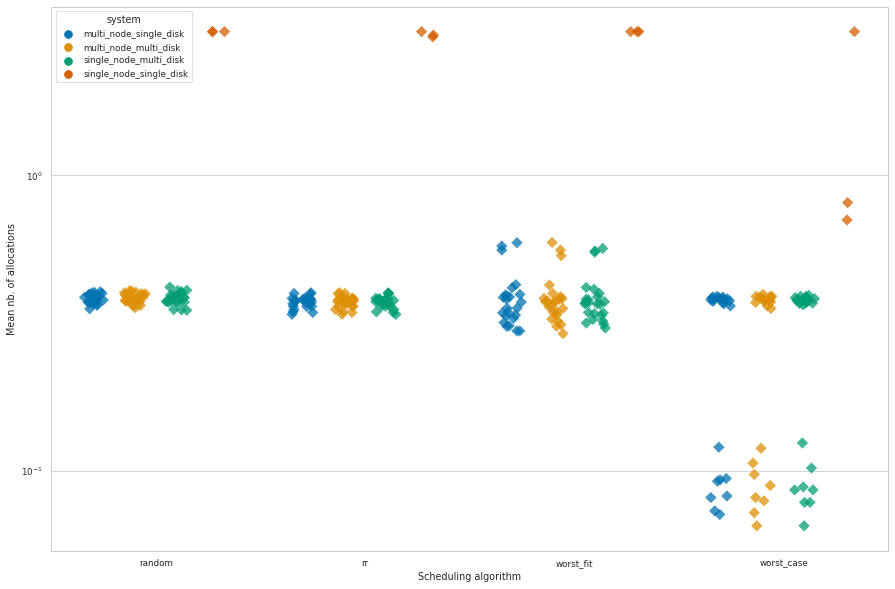

In [43]:
# [9] ---  Mean number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2, order=algo_order
)
g.set(yscale="log")
g.set(ylabel="Mean nb. of allocations", xlabel="Scheduling algorithm")

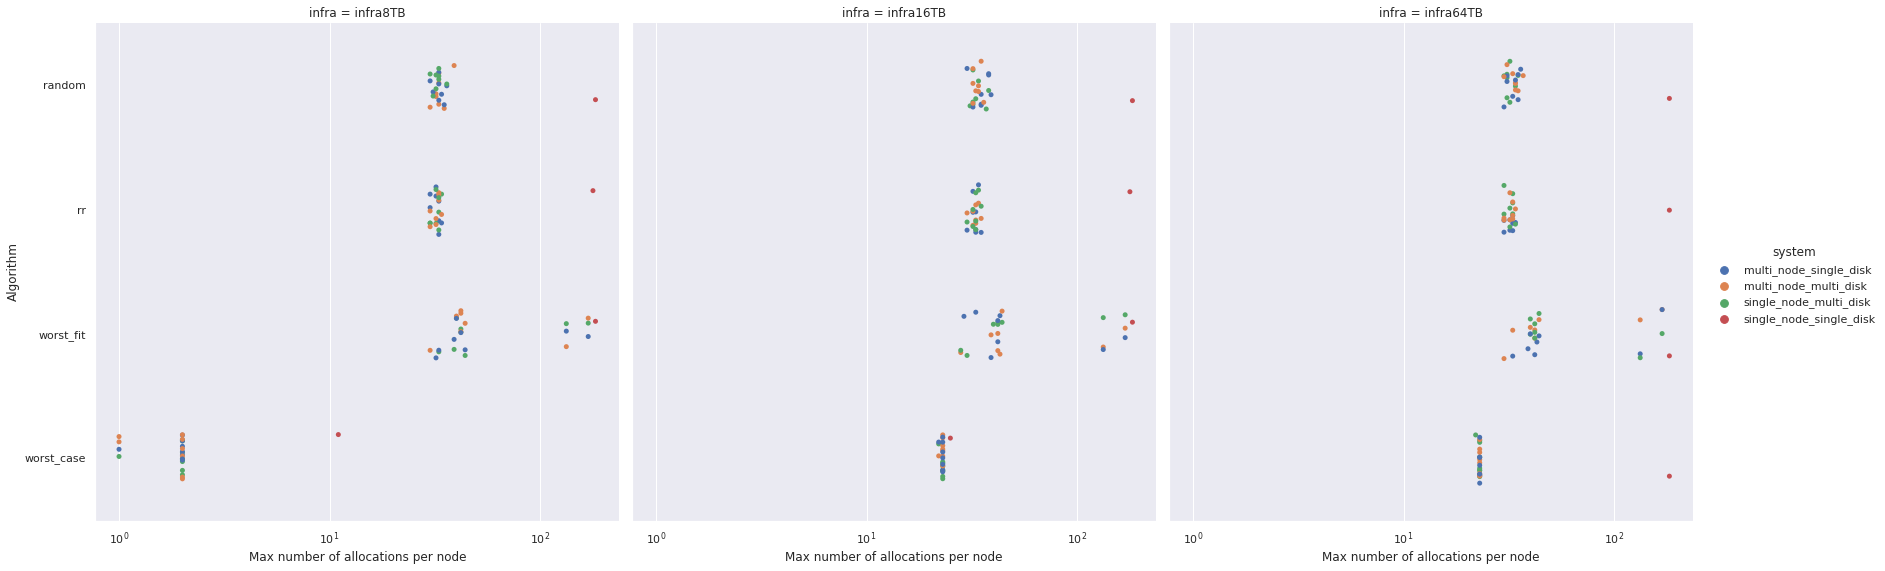

In [49]:
# [10] ---  Max number of allocations per disk, organised by simulation run and infrastructure (1/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
#sns.set_theme(**categorical_theme_disk)

g = sns.catplot(
    data=data_by_disk, kind="strip", col="infra",
    y="algo", x="disk_max_nb_alloc",hue="system",
    height=8, jitter=0.2,
    col_order=infra_order, order=algo_order
)
g.set(xscale="log")
g.set_axis_labels("Max number of allocations per node", "Algorithm")

[Text(0, 0.5, 'Algorithm'), Text(0.5, 0, 'Max number of allocations per node')]

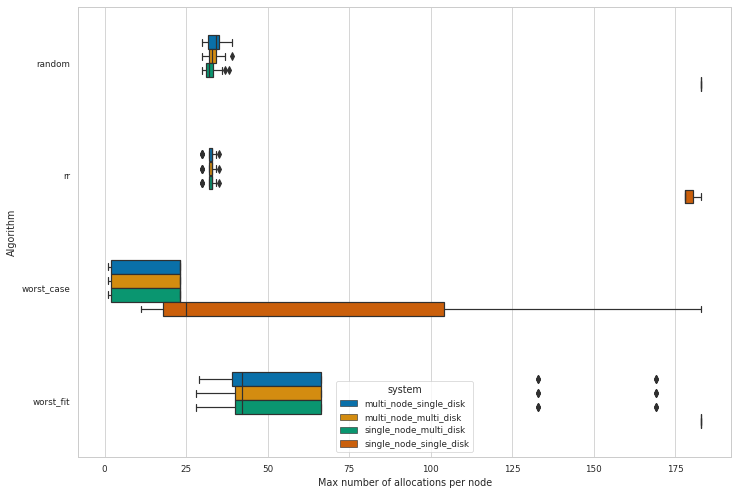

In [55]:
# [11] ---  Max number of allocations per disk, organised by simulation run and infrastructure (2/2)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(**categorical_theme_disk)


g = sns.boxplot(
    data=data_by_disk,
    y="algo", x="disk_max_nb_alloc", hue="system",
    dodge=True, width=0.5, saturation=0.9
)
g.set(ylabel="Algorithm", xlabel="Max number of allocations per node")

[Text(0, 0.5, 'Max nb. of allocations'), Text(0.5, 0, 'Scheduling algorithm')]

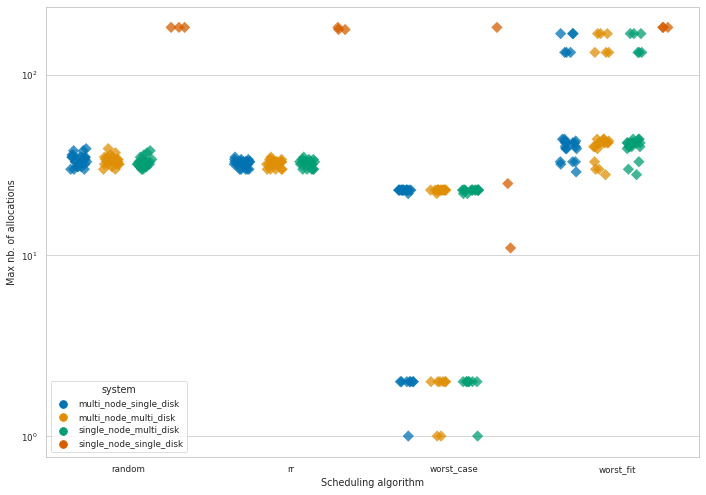

In [56]:
# [12] ---  Max number of allocations per disk, per algorithm (alt)

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_nb_alloc", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(yscale="log")
g.set(ylabel="Max nb. of allocations", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Mean capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

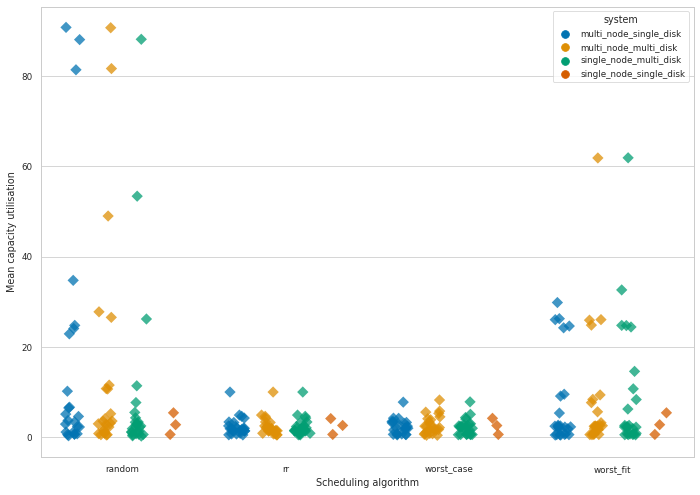

In [57]:
# [13] ---  Mean capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_mean_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Mean capacity utilisation", xlabel="Scheduling algorithm")

[Text(0, 0.5, 'Max capacity utilisation'),
 Text(0.5, 0, 'Scheduling algorithm')]

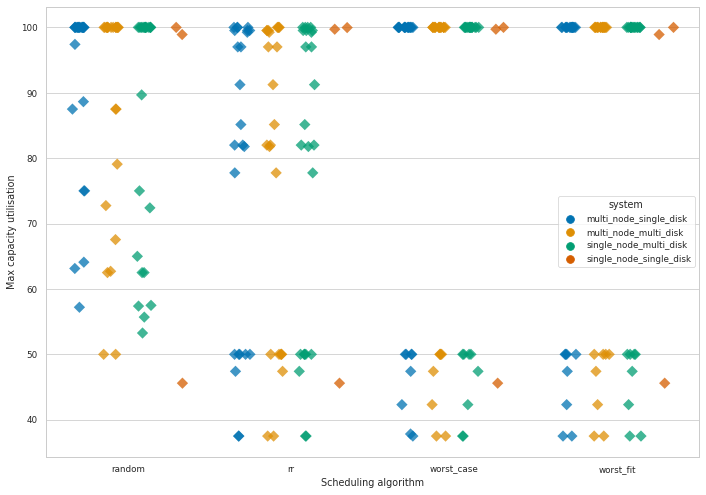

In [58]:
# [14] --- Max capacity utilisation per disk, per algorithm

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk,
    y="disk_max_cap_percent", x="algo",
    hue="system", marker="D",  alpha=.75, dodge=True, size=8, jitter=0.2
)
g.set(ylabel="Max capacity utilisation", xlabel="Scheduling algorithm")

In [59]:
data_by_disk_mean_alloc = data_by_disk.sort_values(["disk_mean_nb_alloc",], ascending=True)

[None]

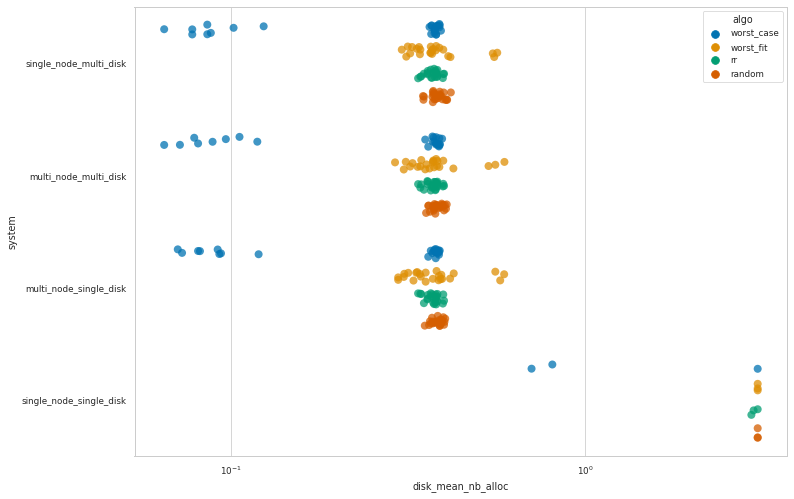

In [61]:
# [15] --- Disk mean nb alloc per run, with hue on Node ID 

sns.set_theme(**categorical_theme_disk)

g = sns.stripplot(
    data=data_by_disk_mean_alloc,
    y="system", x="disk_mean_nb_alloc",size=8, jitter=0.2, alpha=0.75,
    dodge=True,
    hue="algo",
)
g.set(xscale="log")


# g.xaxis.grid(True, "minor", linewidth=.25)
#g = sns.catplot(x="disk_mean_nb_alloc", y="run_name",
#                hue="node_id",
#                data=data_by_disk_sorted, kind="swarm",
#                alpha=.6, height=21, aspect=29.7/21);

#g.set(xscale="log")
# g.xaxis.grid(True, "minor", linewidth=.25)

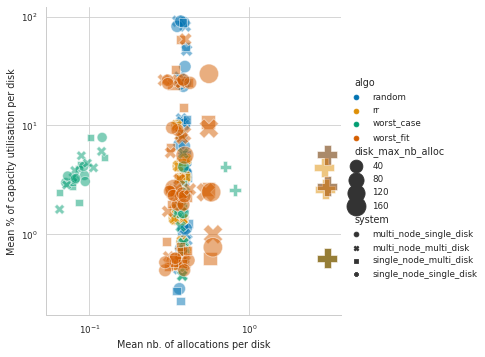

In [68]:
# [16] --- Disk mean nb of alloc compared to disk mean capacity utilisation

sns.set(rc={'figure.figsize':(29.7,21)})
sns.set_theme(**categorical_theme_disk)

#sns.set_style("whitegrid")
g = sns.relplot(
    x="disk_mean_nb_alloc", 
    y="disk_mean_cap_percent", 
    hue="algo", 
    style="system",
    size="disk_max_nb_alloc",
    sizes=(100, 400), 
    alpha=.50,
    height=5, 
    data=data_by_disk
)
g.set(
    xscale="log", 
    yscale="log", 
    xlabel="Mean nb. of allocations per disk", 
    ylabel="Mean % of capacity utilisation per disk"
)

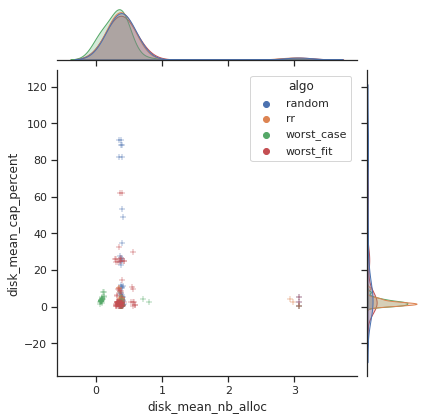

In [24]:
# [16] ---

sns.set_theme(style="ticks")

cmap = sns.hls_palette(n_colors=data_by_disk['algo'].nunique())

g = sns.jointplot(data=data_by_disk, x="disk_mean_nb_alloc", 
                  y="disk_mean_cap_percent", 
                  hue="algo", marker="+")
#g.set(
#    xscale="log", 
#    yscale="log", 
#    xlabel="Mean nb. of allocations per disk", 
#    ylabel="Mean % of capacity utilisation per disk"
#)